Problem statement

Classify a X-Ray image as being normal or Tuberculosis(TB).

Import libraries

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

Define path

In [25]:
import pathlib

data_dir = "./TB_Chest_Radiography_Database" # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('TB_Chest_Radiography_Database')

Define classes

In [26]:
normal = list(data_dir.glob('Normal/*'))
tb = list(data_dir.glob('Tuberculosis/*'))

print("Length of normal: ", len(normal))
print("Length of tb: ", len(tb))

Length of normal:  3500
Length of tb:  700


Print random images

2779
613


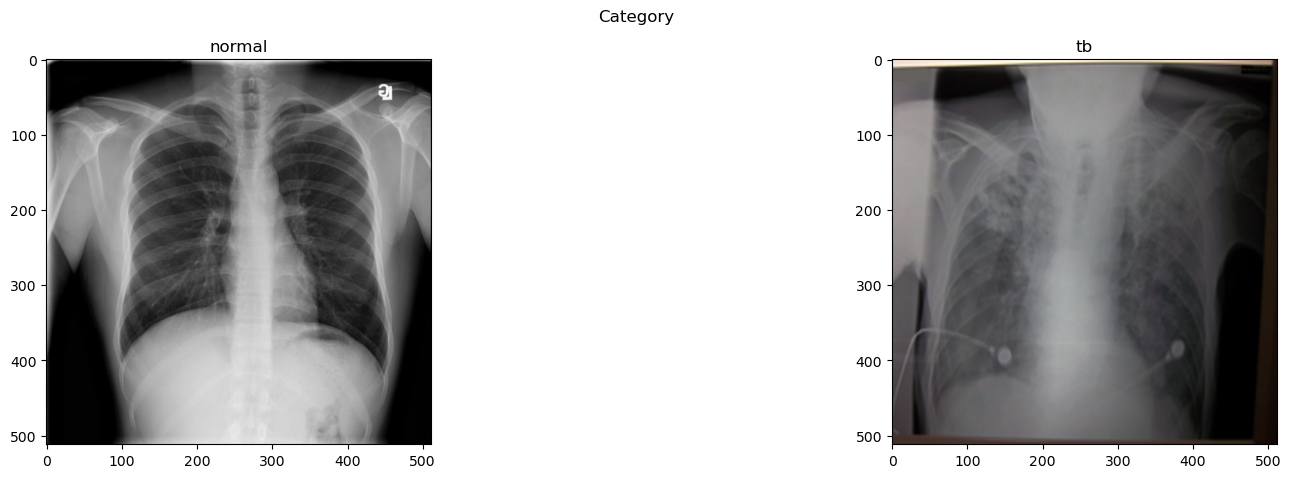

In [27]:
import matplotlib.image as img
import PIL.Image as Image

fig, ax = plt.subplots(ncols= 2, nrows = 1, figsize=(20,5))
fig.suptitle('Category')

rand_normal = np.random.randint(-1,len(normal))
print(rand_normal)

rand_tb = np.random.randint(-1, len(tb))
print(rand_tb)

normal_image = img.imread(normal[rand_normal])
tb_image = img.imread(tb[rand_tb])

ax[0].set_title('normal')
ax[1].set_title('tb')

ax[0].imshow(normal_image)
ax[1].imshow(tb_image)


Define dataframe

In [28]:
# contains the images path

df_images = {
    'normal' : normal,
    'tb' : tb
}

# contains numerical labels for the categories
df_labels = {
    'normal' : 0,
    'tb' : 1
}

Get shape of image

In [29]:
import cv2

img = cv2.imread(str(df_images['tb'][rand_tb])) # Converting it into numerical arrays
img.shape

(512, 512, 3)

Define X and y

In [30]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on the model
        X.append(resized_img) 
        y.append(df_labels[label])
print(len(X), len(y))

KeyboardInterrupt: 

Convert X and y to numpy arrays

In [ ]:
X = np.array(X)
y = np.array(y)

Split X and y into training, validation, and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size = 0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3360, 224, 224, 3),
 (210, 224, 224, 3),
 (630, 224, 224, 3),
 (3360,),
 (210,),
 (630,))

Tensorflow

In [ ]:
import tensorflow as tf 
from tensorflow import keras 
# import tensorflow_hub as hub
from tensorflow.keras.applications import DenseNet169
from keras.callbacks import ModelCheckpoint, EarlyStopping
print(tf.__version__)

2.12.0


Normalise data

In [ ]:
normalizer = tf.keras.layers.Rescaling(scale=1/255)

Define input shape to pretrained models

In [ ]:
input_shape = (224, 224, 3)
input_layer = keras.Input(shape = (224, 224, 3))

Set up pretrained models

In [ ]:
input_shape = (224, 224, 3)

dense_net = DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)

for layer in dense_net.layers:
    layer.trainable = False

Define model

In [ ]:
num_label = len(np.unique(y)) # number of labels

model = keras.Sequential([
    keras.Input(shape=(224,224,3)),
    normalizer,
    dense_net,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_label, activation = 'softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 256)               20873472  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 33,516,866
Trainable params: 20,873,986
No

In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1)
mc = ModelCheckpoint ('best_model12.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping, mc])

Epoch 1/30


2023-09-20 21:47:52.724579: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/opt/homebrew/Caskroom/miniconda/base/envs/sdaia-project/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


105/105 [==============================] - 105s 970ms/step - loss: 1.4491 - acc: 0.9491 - val_loss: 0.1609 - val_acc: 0.9857
Epoch 2/30
105/105 [==============================] - 99s 942ms/step - loss: 0.0467 - acc: 0.9887 - val_loss: 0.0621 - val_acc: 0.9905
Epoch 3/30
105/105 [==============================] - 101s 958ms/step - loss: 0.0237 - acc: 0.9929 - val_loss: 0.0735 - val_acc: 0.9905
Epoch 4/30
105/105 [==============================] - 100s 952ms/step - loss: 0.0318 - acc: 0.9914 - val_loss: 0.0729 - val_acc: 0.9905
Epoch 5/30
105/105 [==============================] - 99s 940ms/step - loss: 0.0221 - acc: 0.9911 - val_loss: 0.0866 - val_acc: 0.9905
Epoch 6/30
105/105 [==============================] - 382s 4s/step - loss: 0.0152 - acc: 0.9964 - val_loss: 0.0881 - val_acc: 0.9905
Epoch 7/30
105/105 [==============================] - 118s 1s/step - loss: 0.0083 - acc: 0.9967 - val_loss: 0.0772 - val_acc: 0.9905
Epoch 8/30
105/105 [==============================] - 132s 1s/step 

In [31]:
from keras.models import load_model
model = load_model('./best_model12.h5')

Make predictions

In [32]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred_bool

10/10 [==============================] - 20s 2s/step


array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [33]:
from sklearn.metrics import accuracy_score

total_right = accuracy_score(y_test, y_pred_bool, normalize=False)
print(total_right)
accuracy = (total_right / len(y_test))
print(accuracy)

626
0.9936507936507937


In [21]:
model.evaluate(X_test,y_test)

/opt/homebrew/Caskroom/miniconda/base/envs/sdaia/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-09-20 21:30:30.683926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 10s 326ms/step - loss: 0.7799 - acc: 0.9841


[0.7799406051635742, 0.9841269850730896]

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test,  y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       527
           1       0.97      0.99      0.98       103

    accuracy                           0.99       630
   macro avg       0.98      0.99      0.99       630
weighted avg       0.99      0.99      0.99       630



In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_bool)
print(cm)
TP = cm[0,0]
print(TP)
FP = cm[0,1]
print(FP)
FN = cm[1,0]
print(FN)
TN = cm[1,1]
print(TN)

[[523   4]
 [  6  97]]
523
4
6
97


In [35]:
# Imports
from mlxtend.plotting import plot_confusion_matrix

# Classes
classes = ['Normal', 'Tuberculosis']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

ModuleNotFoundError: No module named 'mlxtend'

In [26]:
df = pd.DataFrame({'actual': y_test, 'predicted': y_pred_bool})
df

,actual,predicted
0,0,0
1,0,0
2,0,0
3,0,1
4,1,1
...,...,...
625,1,1
626,0,0
627,0,0
628,0,0


In [29]:
from skimage.io import imread, imshow
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [32]:
# Load the image
img_path = './TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-100.png'  # Replace with the path to your image
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

y_pred = model.predict(img)
y_pred
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred_bool


2023-09-20 21:35:22.578129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


array([1])